# Bug in ApRESBurst.define_data_shape
This note examines a bug where the bursts were getting reshaped incorrectly by bas-apres. The attenuator setting dimension $m$ was being added at the end of data_shape, but this meant that when you reshape the flat array of burst data back into a 2- or 3d array it was ending up with the data in the wrong place (m bursts would appear in the first 40001 samples all concatenated, but only every mth sample would be present).

In [24]:
%reload_ext autoreload
import sys
sys.path.append("../../../xapres")
import xapres as xa
import matplotlib.pyplot as plt
import os
import numpy as np

## loading using xapres
load some data from various dat files using xapres (which call bas-apres)

I found the dat files which had more than one attenuator settin sufferend from the bug. 
Even on dat files which I had been using in test prior to this

THe bug does not raise an error, it just reshapes the data incorrectly and makes a chirp that is the right length but is a mix of two different chirps.

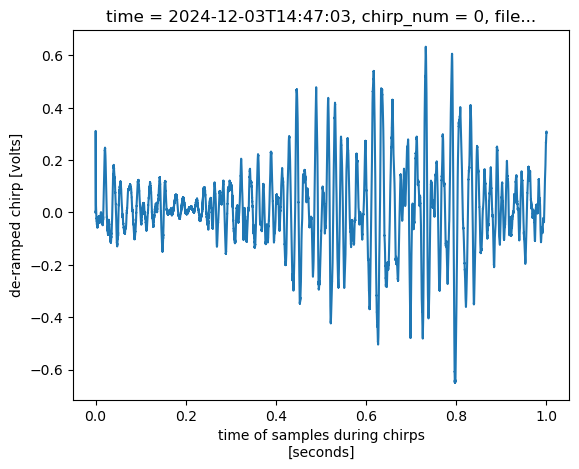

In [ ]:
fd = xa.load.from_dats()

# 
unattended_FG   = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/7.12.2024_Site2_unattended/Data/DATA2024-12-09-0258.DAT'
edited_FG   = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/7.12.2024_Site2_unattended/Data/edited.DAT'
attended_FG = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/7.12.2024_Site2_attended/Data/Survey_2024-12-07_185459_site2HH.dat'
multi_burst_TG = '/Users/jkingslake/Documents/science/ApRES/xapres/data/sample/multi-burst-dat-file/DATA2022-05-22-1939.DAT'
sameAsMatlab_TG = '/Users/jkingslake/Documents/science/ApRES/xapres/data/sample/thwaites/DATA2023-02-12-0437.DAT'
baseCampeTests_FG = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/3.12.2024_Base_camp_tests/Raw_Data/Survey_2024-12-03_144553_207_basecamp_HH.dat'

c = fd.load(baseCampeTests_FG, attended=False)

c.isel(chirp_num=0, attenuator_setting_pair=0).chirp.plot()


In [14]:
c=fd.load_all('/Users/jkingslake/Documents/science/ApRES/xapres/data/sample/multi-burst-dat-file/')
c

<xarray.Dataset>
Dimensions:          (time: 13, chirp_num: 20, attenuator_setting_pair: 2,
                      chirp_time: 40001, profile_range: 39999)
Coordinates:
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-05-22...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    filename         (time) <U23 'DATA2022-05-22-1939.DAT' ... 'DATA2022-05-2...
    folder_name      (time) <U20 'multi-burst-dat-file' ... 'multi-burst-dat-...
    burst_number     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    AFGain           (attenuator_setting_pair) int64 -14 -14
    attenuator       (attenuator_setting_pair) float64 10.0 20.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
  * profile_range    (profile_range) float64 0.0 0.2103 ... 8.411e+03 8.411e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_num, attenuator_setting_pair, chirp_time) float64 ...
    latitude         (time) float64 69.22 69.22 69.22 ... 69.22 69.22 69.22
    longitude        (time) float64 -51.12 -51.12 -51.12 ... -51.12 -51.12
    battery_voltage  (time) float64 12.33 12.48 12.51 12.56 ... 12.49 12.5 12.47
    temperature_1    (time) float64 4.383 7.32 7.32 5.75 ... 9.086 9.477 4.773
    temperature_2    (time) float64 5.195 1.469 5.0 3.82 ... 5.594 6.969 3.625
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 ...
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000.0, 'f_...
    processing:  Created on 2025-01-24 15:37:39.039210

# extract just the call to apres from inside xapres
and use it to load the bursts

this was also triggering the bug

In [21]:
#dat_filename = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/7.12.2024_Site2_attended/Data/Survey_2024-12-07_185459_site2HH.dat'
#dat_filename ='/Users/jkingslake/Documents/science/ApRES/xapres/data/sample/multi-burst-dat-file/DATA2022-05-22-1939.DAT'
dat_filename = baseCampeTests_FG

import apres as ap
with ap.ApRESFile(dat_filename) as f: 
    f.read()

In [22]:
f.bursts[0].data.shape
data = f.bursts[0].data.astype(float)

array([-128., -324.])

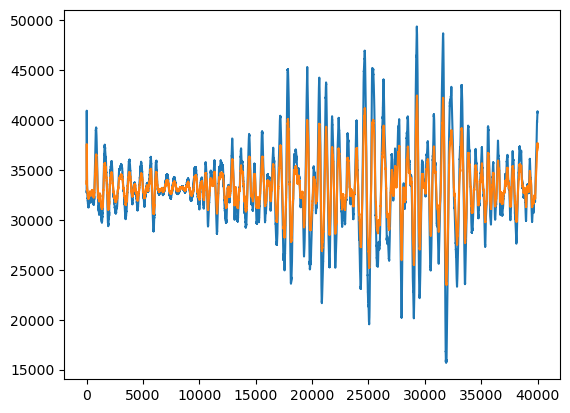

In [ ]:
plt.plot(data[0,0,:])
plt.plot(data[0,1,:])
#plt.xlim([0, 25])

data[0,:,1] - data[0,:,0]

## extract the loading code from inside apres

This helped to find the bug. 

The cell below loads a 1D array of data `burst_flat_FG` and then reshapes it. Playing with the order of reshaping helped to work out that the issue was that the chirp_time dimension needs to be at the end (just because of the way the data is arranged in the dat file). This was the case when nAttenuator=0, but when nAttenuator>0, ApRESBurst.define_data_shape was adding in an attenuator dimension at the end of the data_shape, which was causing the reshaping to be incorrect.

(some of the numbers in the cell below came from running the whole bas-apres code and stopping it in the debugger and copying the values)

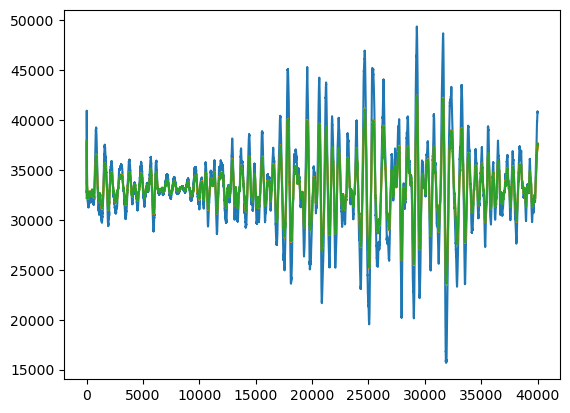

In [ ]:
path = baseCampeTests_FG
fp = open(path, 'r', encoding='latin-1')
file_size = os.fstat(fp.fileno()).st_size
header_start = fp.tell()
header_start

#while not fp.tell() >= file_size:


count = int(np.prod((20,40000,2)))
fp.seek(1316, 0)
burst_flat_FG = np.fromfile(fp, dtype=np.dtype('<u2'), count=1600000)

burst_reshaped = burst_flat_FG.reshape((20, 2, 40000))

# playing with which chirps we plot helped to establish that this is the correct reshaping
burst_reshaped.shape
plt.plot(burst_reshaped[0,0,:])
plt.plot(burst_reshaped[0,1,:])
plt.plot(burst_reshaped[1,1,:])

Do the same thing again but with a differnt dat file. 

Text(0.5, 1.0, 'correct reshaping leads to this:')

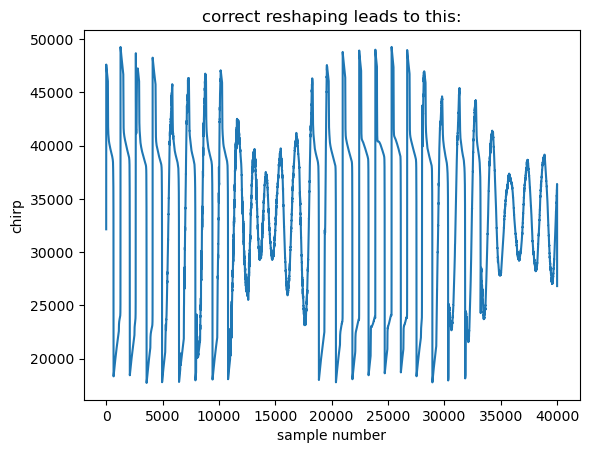

In [32]:
path = multi_burst_TG
fp = open(path, 'r', encoding='latin-1')
file_size = os.fstat(fp.fileno()).st_size
header_start = fp.tell()
header_start

#while not fp.tell() >= file_size:


count = int(np.prod((20,40001,2)))
fp.seek(1355, 0)
burst_flat = np.fromfile(fp, dtype=np.dtype('<u2'), count=1600040)

burst_reshaped_TG = burst_flat.reshape((20, 2, 40001))

burst_reshaped_TG.shape
plt.plot(burst_reshaped_TG[0,0,:])
plt.xlabel('sample number')
plt.ylabel('chirp')
plt.title('correct reshaping leads to this:')
#plt.plot(burst_reshaped_TG[5,1,:])

## recreate a plot like the one wewere seeing due to the bug:

Text(0.5, 1.0, 'incorrect reshaping leads to this:')

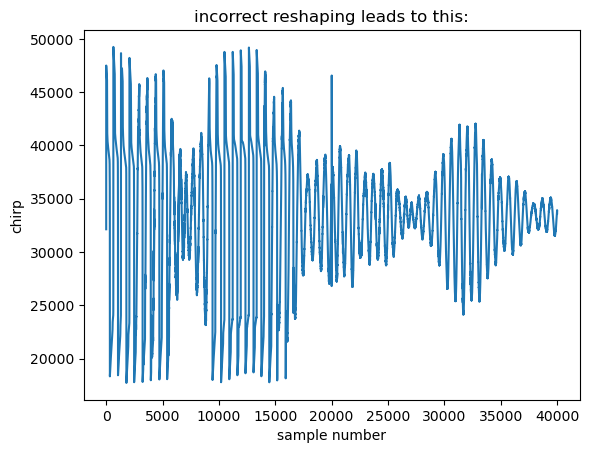

In [35]:
burst_reshaped_TG = burst_flat.reshape((20, 40001, 2))

plt.plot(burst_reshaped_TG[0,:,0])
plt.xlabel('sample number')
plt.ylabel('chirp')
plt.title('incorrect reshaping leads to this:')
#plt.plot(burst_reshaped_TG[5,1,:])